# A Model for Rankings

---

In [1]:
# Necessary imports
from ranking_system import *
%matplotlib inline

---

$r_u(t)$ = the ranking of university $u$ at time $t$.

We'll use $t$ to represent time, which will generally think of
as discrete. Thus $r_u(t-1)$ is university $u$'s ranking the year before.

---

In [2]:
# Time steps
T = 10

# Universities
U = 2

---

Let $M$ be the number of attributes in the ranking.

---

In [3]:
# Attributes
M = 2

---

$w_i(t)$ is the weightage given to attribute $i$ in the ranking.
This generally does not change frequently.

---

In [4]:
# Create weightage functions
# Return the weight used for ranking attribute i at time t
# The sum of the M weightage functions at time t must add up to 1


def weightage_average_spending_per_student(t):
    """Weight given to average spending per student attribute
       Decreases at time t greater than 5"""
    return 0.7 if t < 5 else 0.6


def weightage_average_class_size(t):
    """Weight given to average class size attribute
       Increases at time t greater than 5"""
    return 0.3 if t < 5 else 0.4

---

The _valuation_ functions $V_i$ need a little explanation.

Think of them as the true valuation of a particular attribute, complete with
lower/upper bounds and potential non-linearities.

For example, consider the attribute "average class size". A ranking could ignore class sizes below 5, and could likewise scale up non-linearly so that a class size of 300 is not much worse than a class size of 200. This means that one could have a step-like $V_i$ function for class sizes to give us the actual value used in the weighted score.

---

In [5]:
# Create valuation functions
# Return the true valuation of attribute i at time t 


def valuation_average_spending_per_student(average_spending_per_student):
    """Valuation given to the average spending per student attribute"""
    # Step like function for average spending per student
    if average_spending_per_student > 10_000:
        # Spending more than 10,000 per student receives the most credit
        return 100
    elif average_spending_per_student > 7_500:
        # Spending between 7,500 and 10,000 per student scores second highest
        return 75
    elif average_spending_per_student > 5_000:
        # Spending between 5,000 and 7,500 per student scores third highest
        return 50
    elif average_spending_per_student > 2_500:
        # Spending between 2,500 and 5,000 per student scores fourth highest
        return 25
    else:
        # Spending less than 2,500 per student receives no credit
        return 0

    
def valuation_average_class_size(average_class_size):
    """Valuation given to the average class size attribute"""
    # Step like function for average class size
    if average_class_size < 20:
        # Classes with fewer than 20 students receive the most credit
        return 100
    elif average_class_size < 30:
        # Classes with 20 to 29 students score second highest
        return 75
    elif average_class_size < 40:
        # Classes with 30 to 39 students score third highest
        return 50
    elif average_class_size < 50:
        # Classes with 40 to 49 students score fourth highest
        return 25
    else:
        # Classes that are 50 or more students receive no credit
        return 0

---

Let $x_{i,u}(t)$ be the funding allocated to attribute $i$ by university $u$.

$y_{i,u}(t)$ = the value of university $u$'s i-th attribute,
where $i$ ranges from 1 to $M$.

Define the _production_ functions $P_{i,u}$ as

   $$
        y_{i,u}(t) = P_{i,u}( x_{i,u}(t) )
   $$

Here, the idea is to model non-linearities. 

Simply adding dollars does not decrease class-sizes linearly.

There may be floors, ceilings or other non-linearities, and universities will differ in these "bang-for-the-buck" functions.

---

In [6]:
# Create production functions


def production_average_spending_per_student(dollars, random):
    """Production function for the average spending per student attribute"""
    # Educational: spending on instruction, research, and student services
    # Non-educational: spending on sports, dorms, and hospitals
    # Universities will differ in the percentage of dollars spent on educational
    # versus non-educational resources.
    # The educational spending percentage may change from year to year.
    educational_spending_percentage = random.uniform(0.5, 1)
    return dollars * educational_spending_percentage


def production_average_class_size(dollars, random):
    """Production function for the average class size attribute"""
    if dollars > random.uniform(9_000, 10_000):
        return 10
    elif dollars > random.uniform(6_000, 9_000):
        return 20
    elif dollars > random.uniform(3_000, 6_000):
        return 30
    elif dollars > random.uniform(2_000, 3_000):
        return 40
    elif dollars > random.uniform(1_000, 2_000):
        return 50
    elif dollars > random.uniform(500, 1_000):
        return 100
    else:
        return 200

In [7]:
# Create a list of M attributes 
# Parameters: name, weightage function, valuation function, production function

attributes = [Attribute('Average Spending Per Student',
                        weightage_average_spending_per_student,
                        valuation_average_spending_per_student,
                        production_average_spending_per_student),
              Attribute('Average Class Size',
                        weightage_average_class_size,
                        valuation_average_class_size,
                        production_average_class_size)]

---

For each epoch $t$ a university has a total expenditure

   $$
       C_u(t) = \sum_{i} x_{i,u}(t)
   $$

Put another way, we can think of $C_u(t)$ as the total budget
(the constraint) for epoch $t$. This could be different year-to-year.

---

In [8]:
# Set the total expenditure settings
# Each year the university will receive a total budget that is a
# uniform random variable between expenditure_min and expenditure_max

settings = {'expenditure_min': 5_000, 'expenditure_max': 15_000}

---

We will now define the _score_ of a university as

$$
     \mu_u(t) = \sum_{i} w_i(t) V_i(y_{i,u}(t))
$$

The ranking then, is just an ordering of the universities in epoch
$t$ using their $\mu_u(t)$ values.

Thus, the optimization function for a university (the "agent") is now clear: 

* identify the optimal values of $x_{i,u}(t)$ to maximize $\mu_u(t)$.

---

In [9]:
# Create a new model
model = RankingModel(U, attributes, settings, random_seed=13579)

# Run the model for T time steps
model.run(T)

,University,Time,Funding,Production,Valuation,Weight,Score
0,University 1,1,6530.23,5020.53,50,0.7,35.0
1,University 2,1,6805.82,6613.76,50,0.7,35.0
2,University 1,2,4747.42,4366.23,25,0.7,17.5
3,University 2,2,8113.99,5743.28,50,0.7,35.0
...,...,...,...,...,...,...,...
16,University 1,9,924.02,753.85,0,0.6,0.0
17,University 2,9,7903.77,7317.69,50,0.6,30.0
18,University 1,10,16761.00,14813.82,100,0.6,60.0
19,University 2,10,5823.82,4311.86,25,0.6,15.0


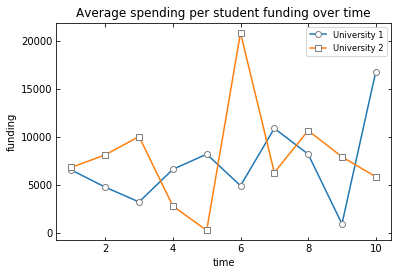

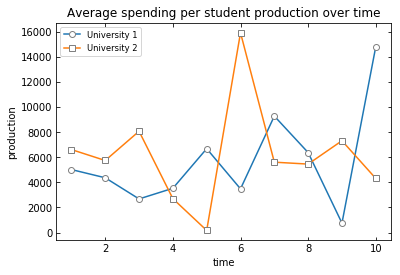

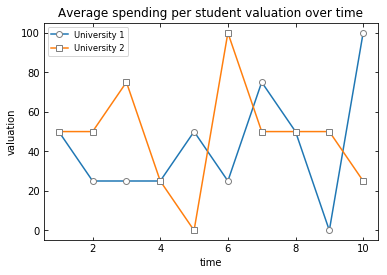

In [10]:
# Display the attribute values
display_attribute(model, 'Average Spending Per Student', all_rows=False)

# Plot the attribute funding over time
line_plot(find_values_by_agent(model, 'Average Spending Per Student', 'funding'),
          'time', 'funding', 'Average spending per student funding over time')

# Plot the attribute production over time
line_plot(find_values_by_agent(model, 'Average Spending Per Student', 'production'),
          'time', 'production', 'Average spending per student production over time')

# Plot the attribute valuation over time
line_plot(find_values_by_agent(model, 'Average Spending Per Student', 'valuation'),
          'time', 'valuation', 'Average spending per student valuation over time')

,University,Time,Funding,Production,Valuation,Weight,Score
0,University 1,1,111.59,200,0,0.3,0.0
1,University 2,1,3139.96,40,25,0.3,7.5
2,University 1,2,271.71,200,0,0.3,0.0
3,University 2,2,3017.59,40,25,0.3,7.5
...,...,...,...,...,...,...,...
16,University 1,9,4485.36,40,25,0.4,10.0
17,University 2,9,706.91,200,0,0.4,0.0
18,University 1,10,389.21,200,0,0.4,0.0
19,University 2,10,3482.06,40,25,0.4,10.0


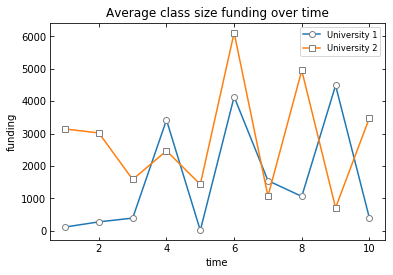

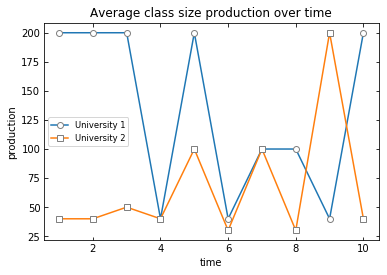

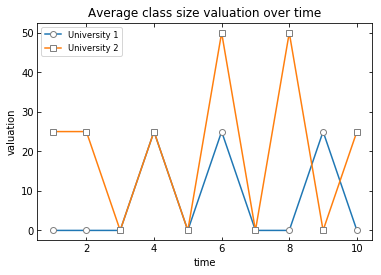

In [11]:
# Display the attribute values
display_attribute(model, 'Average Class Size', all_rows=False)

# Plot the attribute funding over time
line_plot(find_values_by_agent(model, 'Average Class Size', 'funding'),
          'time', 'funding', 'Average class size funding over time')

# Plot the attribute production over time
line_plot(find_values_by_agent(model, 'Average Class Size', 'production'),
          'time', 'production', 'Average class size production over time')

# Plot the attribute valuation over time
line_plot(find_values_by_agent(model, 'Average Class Size', 'valuation'),
          'time', 'valuation', 'Average class size valuation over time')

,University,Time,Rank,Score,Normalized Score
0,University 1,1,2,35.0,82
1,University 2,1,1,42.5,100
2,University 1,2,2,17.5,41
3,University 2,2,1,42.5,100
...,...,...,...,...,...
16,University 1,9,2,10.0,33
17,University 2,9,1,30.0,100
18,University 1,10,1,60.0,100
19,University 2,10,2,25.0,42


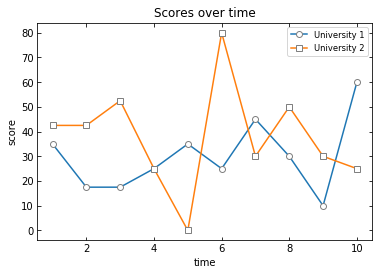

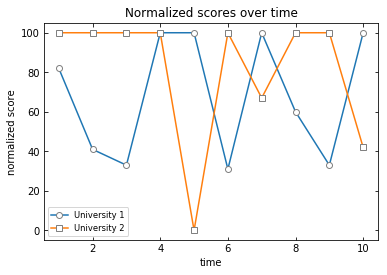

In [12]:
# Display the scores and ranking
display_ranking(model, all_rows=False)

# Plot the university score over time
line_plot(find_values_by_agent(model, 'ranking', 'score'),
          'time', 'score', 'Scores over time')

# Plot the university normalized score over time
line_plot(find_values_by_agent(model, 'ranking', 'normalized_score'),
          'time', 'normalized score', 'Normalized scores over time')

---

Next, let's see if we can develop some notion of "societal value".

Let

  $$
    S_i(t) = \sum_u y_{i,u}(t)
  $$
  
be the total output of attribute $i$ across universities. 
Notice that we're not applying the valuation, but rather, we're
trying to measure raw output (whether useful to ranking or not).

Let $S(t) = \sum_i S_i(t)$ be the total output.

---

,Time,Societal Value
0,1,11874.29
1,2,10349.51
2,3,11003.22
3,4,6310.36
4,5,7157.01
5,6,19476.97
6,7,15091.17
7,8,11961.77
8,9,8311.53
9,10,19365.68


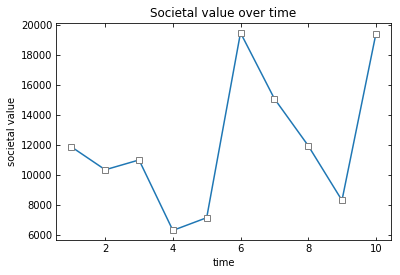

In [13]:
# Display the societal values
display_societal_value(model, all_rows=True)

# Plot the societal values
line_plot(table_column_to_list(model, 'societal_value', 'societal_value'),
          'time', 'societal value', 'Societal value over time')

---

Next, let $D(t)$ be the total change in ranking aggregated across all universities that moved up from the previous year, a sort of "distance moved" in aggregate  by the universities that moved up. This is trying to capture the sheer effort (resources) in moving up the rankings.

Finally, define

  $$
     \gamma (t) = \frac{D(t)}{S(t) - S(t-1)}
  $$

This is trying to measure the ratio of total positive dynamic movement to the actual change in value to society. Clearly, if the total change in output is modest and the ranking-movement is high, one could say that this is not useful to society. 

Then, one could work backwords and compute $\delta(t)$, the amount "wasted" on this game of musical chairs.

---